In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
dataset_path = "/content/drive/MyDrive/Dataset Model 2/ZNStaining"

# Fungsi untuk menghitung jumlah gambar pada setiap label
def count_images_per_label(dataset_path):
    labels = os.listdir(dataset_path)
    counts = {}
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        counts[label] = len(os.listdir(label_path))
    return counts

# Menghitung jumlah gambar pada setiap label sebelum augmentasi
original_counts = count_images_per_label(dataset_path)
print("Jumlah gambar per label sebelum augmentasi:", original_counts)

Jumlah gambar per label sebelum augmentasi: {'GoodStaining': 76, 'LessStaining': 40, 'OverStaining': 18}


In [17]:
#Target augmentasi dinamis
target_counts = {
    'GoodStaining': int(original_counts['GoodStaining'] * 1.5),
    'LessStaining': int(original_counts['LessStaining'] * 2),
    'OverStaining': 80
}
print("Target jumlah gambar per label setelah augmentasi:", target_counts)

Target jumlah gambar per label setelah augmentasi: {'GoodStaining': 114, 'LessStaining': 80, 'OverStaining': 80}


In [21]:
# Augmentasi data untuk menyeimbangkan jumlah gambar
datagen_augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
# Jika jumlah gambar sudah mencapai target, hapus gambar berlebih

def dynamic_augment(label_path, original_count, target_count):
    images = os.listdir(label_path)
    current_count = len(images)

    if current_count >= target_count:
        for img_name in images[target_count:]:
            img_path = os.path.join(label_path, img_name)
            os.remove(img_path)
        return

    # Hitung berapa banyak augmentasi yang dibutuhkan per gambar
    needed = target_count - original_count
    augment_per_image = max(1, needed // original_count)
    remainder = needed % original_count

    for i, img_name in enumerate(images[:original_count]):
        img_path = os.path.join(label_path, img_name)
        img = image.load_img(img_path)
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        total_augments = augment_per_image + (1 if i < remainder else 0)
        for _ in datagen_augment.flow(x, batch_size=1, save_to_dir=label_path,
                                    save_prefix=f'aug_{i}_', save_format='jpeg'):
            total_augments -= 1
            if total_augments <= 0:
                break

In [24]:
# Augmentasi dataset untuk setiap label
for label in original_counts:
    label_path = os.path.join(dataset_path, label)
    dynamic_augment(label_path, original_counts[label], target_counts[label])

In [25]:
# Verifikasi hasil augmentasi
new_counts = count_images_per_label(dataset_path)
print("Jumlah gambar per label setelah augmentasi dinamis:", new_counts)

Jumlah gambar per label setelah augmentasi dinamis: {'GoodStaining': 190, 'LessStaining': 80, 'OverStaining': 79}


In [27]:
# Augmentasi data untuk training dan validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

Found 280 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


In [28]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 280 images belonging to 3 classes.


In [29]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 69 images belonging to 3 classes.


In [30]:
# Build model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
# Training model TANPA callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4463 - loss: 1.1019 - val_accuracy: 0.8438 - val_loss: 0.4848
Epoch 2/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9062 - loss: 0.4058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 0.9062 - loss: 0.4058 - val_accuracy: 0.8281 - val_loss: 0.4638
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9228 - loss: 0.2764 - val_accuracy: 0.7969 - val_loss: 0.6078
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - accuracy: 0.8750 - loss: 0.5521 - val_accuracy: 0.8125 - val_loss: 0.5256
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9131 - loss: 0.2459 - val_accuracy: 0.8750 - val_loss: 0.3679
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.9375 - loss: 0.1556 - val_accuracy: 0.8594 - val_loss: 0.3726
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8963 - loss: 0.2467 - val_accuracy: 0.7812 - val_loss: 0.5255
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.7812 - loss: 0.4863 - val_accuracy: 0.7812 - val_loss: 0.4490
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8837 - loss: 0.2431 - val_accuracy: 0.8281 - val_loss: 0.3124
Epoch 10/50

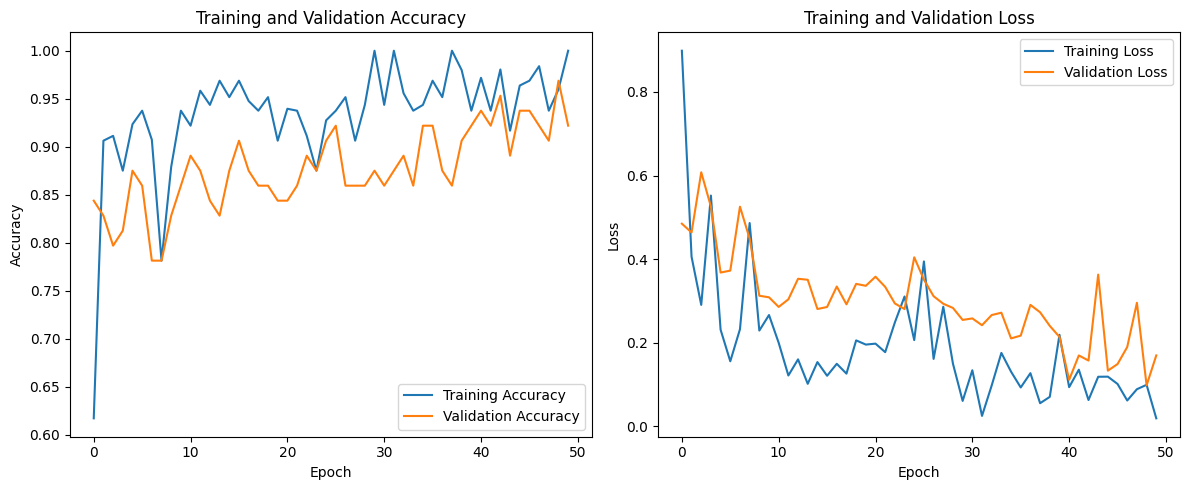

In [33]:
# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 5))

# Grafik Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Evaluasi model
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy*100:.2f}%')


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.9247 - loss: 0.1691

Validation Loss: 0.1621
Validation Accuracy: 92.75%


In [35]:
# Analisis distribusi kelas setelah augmentasi
print("\nDistribusi kelas setelah augmentasi dinamis:")
for label, count in new_counts.items():
    print(f"{label}: {count} gambar (original: {original_counts[label]})")


Distribusi kelas setelah augmentasi dinamis:
GoodStaining: 190 gambar (original: 76)
LessStaining: 80 gambar (original: 40)
OverStaining: 79 gambar (original: 18)
